## Workspace for PSD codes demonstration 

created: **09/09/2022**; last edited: **20/08/2022**

[rafael.celestre@esrf.eu](mailto:rafael.celestre@esrf.eu)

<hr style="border:1px solid gray">

In [1]:
# imports
import sys
print(sys.executable)
print(sys.version)
%matplotlib notebook
import matplotlib.pylab as pl
import numpy as np
from srw_uti_mtrl import * 
from scipy.optimize import curve_fit
import barc4plots.barc4plots as b4pt    # get barc4plots: https://gitlab.esrf.fr/celestre/barc4plots
from IPython import display

/home/esrf/celestre/miniconda/envs/xog/bin/python
3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


## example 1 - simple surface generation

### Surface generation

We first generate a random surface with $\sigma$ as the RMS roughness value in [m], an exponent (negative) for the PSD modelling as $\text{PSD}\sim ax^k$; m and n are the numeber of pixels in the reconstructed profile. $L_x = m \cdot \text{PixelWidth}$ and $L_y = m \cdot \text{PixelWidth}$. The lowest frequency in the PSD is $1/L_{x,y}$ and the highest is $1/(2\cdot\text{PixelWidth})$.

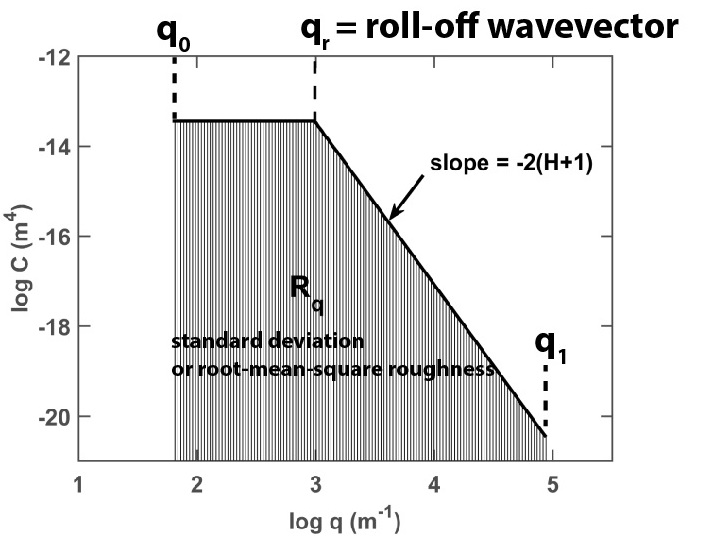

In [2]:
display.Image("./matlab_psd_codes/PSD.jpg")

In [3]:
sigma = 3e-6
exponent = -3.6
PixelWidth = 1e-6
m = 2048
n = 2048
surf, axis_y, axis_x, Cq, qy, qx = fractal_surf(sigma,
                                             exponent,
                                             PixelWidth,
                                             m , n,
                                             qr=0,     # roll off frequency
                                             symmetry=True,
                                             dist=1,   # 0 - uniform; 1 Gaussian phase random distribution
                                             seed=17,  # seed for random phase
                                             psd=True, # we set this to True to have Cq, qx, qy returned - PSD and it's axes
                                             C=None)   # it is possible to add a pre calculated PSD as long as it has the 
                                                       # same shape as Cq and qx and qy are on the same scale

lower_f_limit = 1/axis_x[-1]
upper_f_limit = 1/PixelWidth

cuty = surf[:, int(m/2)]
psf_y, fy = srw_uti_mtrl_psd_1D(cuty, axis_y, positive_side=True)
rms = np.sqrt(np.mean(surf**2))*1e6
print('rms value: %.3f um'%rms)

rms value: 3.000 um


<IPython.core.display.Javascript object>


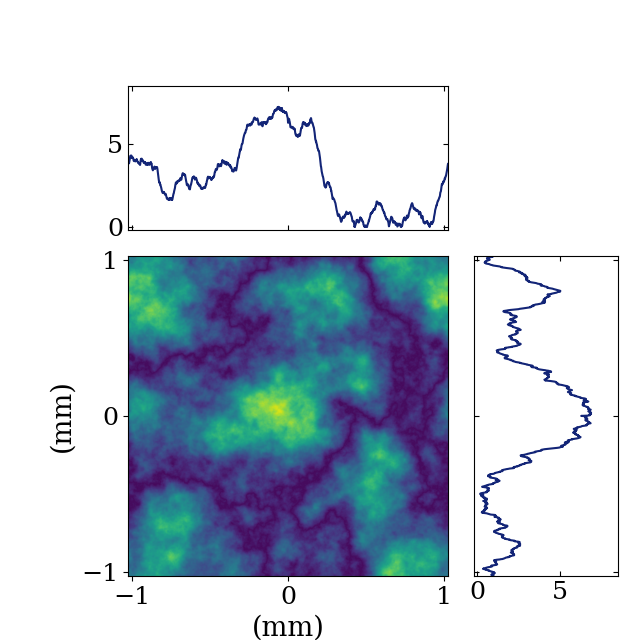

In [4]:
image = b4pt.Image2Plot(surf*1e6, axis_x*1e3, axis_y*1e3)
image.legends = ['', '(mm)', '(mm)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.plt_limits = [-0.2, np.amax(surf*1e6)*1.05]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

### PSD calculation & surface cross-checking

- #### input PSD (Cq)

<IPython.core.display.Javascript object>


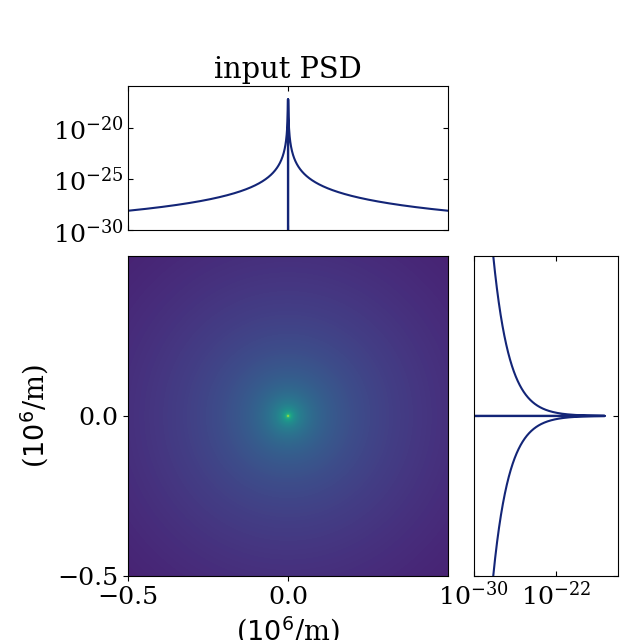

In [5]:
image = b4pt.Image2Plot(Cq, qx*1e-6, qy*1e-6)
image.legends = ['input PSD', '($10^6$/m)', '($10^6$/m)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.Scale=1
image.plt_limits = [1e-30, 1e-16]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

- #### input PSD calculation from the surface _surf_

<IPython.core.display.Javascript object>


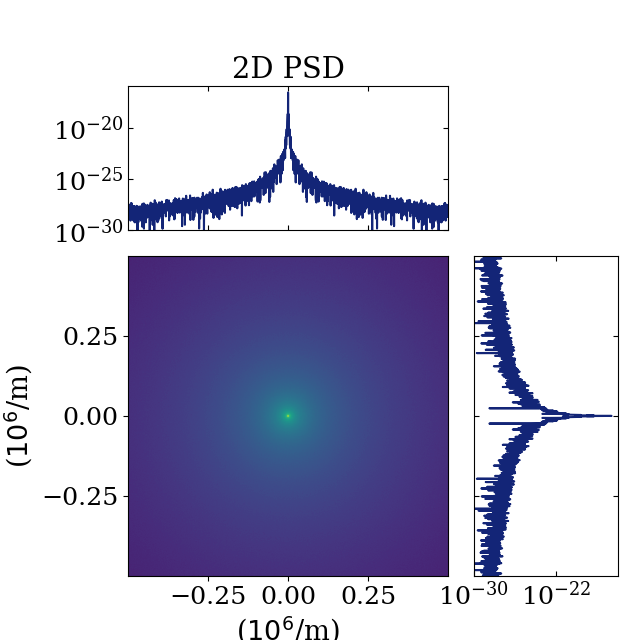

In [6]:
# 2D PSD calculation
psd_2d, fxbis, fybis = srw_uti_mtrl_psd_2D(surf, axis_x, axis_y, pad=False)
cut_x_psd_2d = psd_2d[int(n/2), :]
cut_x_psd_2d = cut_x_psd_2d[fxbis>0]
axis_x_psd_2d = fxbis[fxbis>0]

image = b4pt.Image2Plot(psd_2d, fxbis*1e-6, fybis*1e-6)
image.legends = ['2D PSD', '($10^6$/m)', '($10^6$/m)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.Scale=1
image.plt_limits = [1e-30, 1e-16]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

- #### PSD calculations comp.

In [7]:
# 1D PSD calculation of a profile cut
cutx = surf[int(n/2), :]
psf_x, fx = srw_uti_mtrl_psd_1D(cutx, axis_x, positive_side=True)

# azimuthally averaged PSD from a 2D PSF calculation
psf_avg, f_avg = srw_uti_mtrl_psd_avg(surf, axis_x, axis_y, pad=False)

# input PSD cuts
cut_x_Cq = Cq[int(n/2), :]
cut_x_Cq = cut_x_Cq[qx>0]
axis_x_Cq = qx[qx>0]

<IPython.core.display.Javascript object>


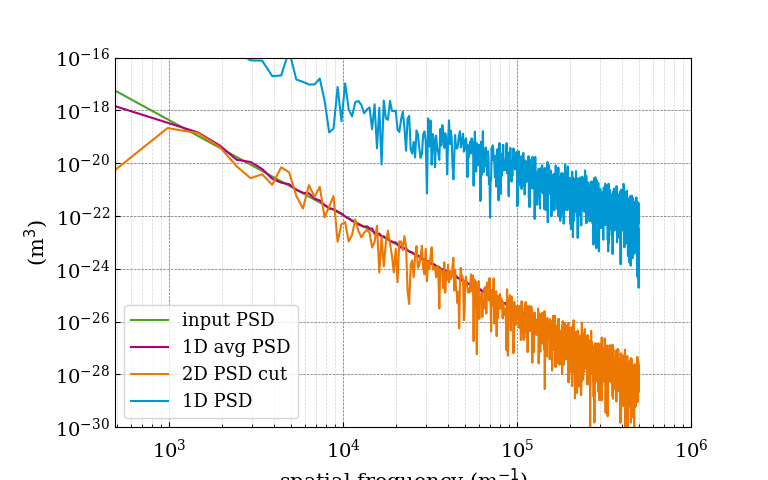

In [8]:
image = b4pt.Image2Plot(cut_x_Cq, axis_x_Cq)
image.AspectRatio = False
image.LaTex = True
image.legends = ['', 'spatial frequency (m$^{-1}$)', '(m$^3$)']
image.Scale = 3
image.ColorScheme = 1
image.label = 'input PSD'
image.grid = True 
image.sort_class()
b4pt.plot_1D(image, Enable=False, Hold=False)

image.image =  psf_avg
image.x = f_avg
image.ColorScheme = 2
image.label = '1D avg PSD'
b4pt.plot_1D(image, Enable=False, Hold=True)

image.image = cut_x_psd_2d
image.x = axis_x_psd_2d
image.ColorScheme = 3
image.label = '2D PSD cut'
b4pt.plot_1D(image, Enable=False, Hold=True)

image.image = psf_x
image.x = fx
image.ColorScheme = 4
image.label = '1D PSD'
image.ax_limits = [lower_f_limit*0.5, upper_f_limit, 1e-30, 1e-16]
b4pt.plot_1D(image, Enable=True, Hold=True)

### Fitting the PSD

Naive fit of:

a-) $\text{psf}=a \cdot x ^k$

as a log-log function:

b-) $\log_{10}\big(\text{psf}\big)=\log_{10}(a)+k\cdot \log_{10}(x)$,

which is a linear function. This is used as initial guess for non-linear least squares



In [9]:
# target function
def saxs(x, k, a):
    return a*(x**k)

In [10]:
lg_psf = np.log10(psf_x)
lg_fx = np.log10(fx)
px = np.polyfit(lg_fx, lg_psf, deg=1)
best_vals = [px[0], 10**px[1]]  # see saxs function
best_vals, covar = curve_fit(saxs, fx, psf_x, p0=best_vals)
perr = np.sqrt(np.diag(covar))

print('initial values: %.3e x ^(%.3f)'%(10**px[1],px[0]))
print('1D PSD approximated by: %.3e x ^(%.3f)'%(best_vals[1],best_vals[0]))
print('>>> err: [%.3e; %.3e]\n'%(perr[1],perr[0]))

lg_psf = np.log10(cut_x_psd_2d)
lg_fx = np.log10(axis_x_psd_2d)
px = np.polyfit(lg_fx, lg_psf, deg=1)
best_vals = [px[0], 10**px[1]]  # see saxs function
best_vals, covar = curve_fit(saxs, cut_x_psd_2d, axis_x_psd_2d, p0=best_vals)
perr = np.sqrt(np.diag(covar))

print('initial values: %.3e x ^(%.3f)'%(10**px[1],px[0]))
print('2D PSD cut approximated by: %.3e x ^(%.3f)'%(best_vals[1],best_vals[0]))
print('>>> err: [%.3e; %.3e]\n'%(perr[1],perr[0]))

lg_psf = np.log10(cut_x_Cq)
lg_fx = np.log10(axis_x_Cq)
px = np.polyfit(lg_fx, lg_psf, deg=1)
best_vals = [px[0], 10**px[1]]  # see saxs function
best_vals, covar = curve_fit(saxs, cut_x_Cq, axis_x_Cq, p0=best_vals)
perr = np.sqrt(np.diag(covar))

print('initial values: %.3e x ^(%.3f)'%(10**px[1],px[0]))
print('input PSD cut approximated by: %.3e x ^(%.3f)'%(best_vals[1],best_vals[0]))
print('>>> err: [%.3e; %.3e]\n'%(perr[1],perr[0]))


initial values: 5.005e-08 x ^(-2.604)
1D PSD approximated by: 3.309e-10 x ^(-1.766)
>>> err: [4.280e-11; 2.055e-02]

initial values: 8.339e-09 x ^(-3.551)
2D PSD cut approximated by: -8.645e-22 x ^(-3.551)
>>> err: [1.712e-20; 1.187e-07]

initial values: 2.667e-08 x ^(-3.600)
input PSD cut approximated by: 1.850e-22 x ^(-3.600)
>>> err: [2.794e-21; 7.487e-09]



## example 2 - surf. generation with qr different from zero

In [11]:
sigma = 3e-6
exponent = -3.6
PixelWidth = 1e-6
m = 2048
n = 2048
surf, axis_y, axis_x, Cq, qy, qx = fractal_surf(sigma,
                                             exponent,
                                             PixelWidth,
                                             m , n,
                                             qr=0.75e4,     # roll off frequency
                                             symmetry=True,
                                             dist=1,   # 0 - uniform; 1 Gaussian phase random distribution
                                             seed=17,  # seed for random phase
                                             psd=True, # we set this to True to have Cq, qx, qy returned - PSD and it's axes
                                             C=None)   # it is possible to add a pre calculated PSD as long as it has the 
                                                       # same shape as Cq and qx and qy are on the same scale

lower_f_limit = 1/axis_x[-1]
upper_f_limit = 1/PixelWidth

cuty = surf[:, int(m/2)]
psf_y, fy = srw_uti_mtrl_psd_1D(cuty, axis_y, positive_side=True)
rms = np.sqrt(np.mean(surf**2))*1e6
print('rms value: %.3f um'%rms)

rms value: 3.000 um


### Surface generation

<IPython.core.display.Javascript object>


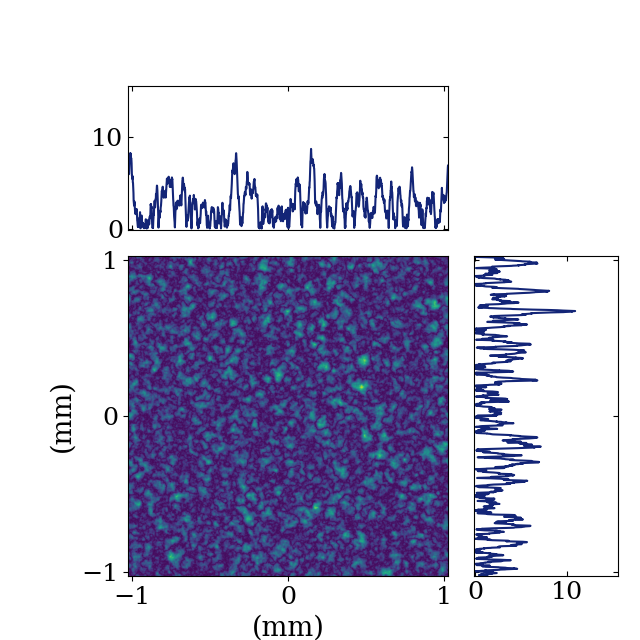

In [12]:
image = b4pt.Image2Plot(surf*1e6, axis_x*1e3, axis_y*1e3)
image.legends = ['', '(mm)', '(mm)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.plt_limits = [-0.2, np.amax(surf*1e6)*1.05]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

### PSD calculation

<IPython.core.display.Javascript object>


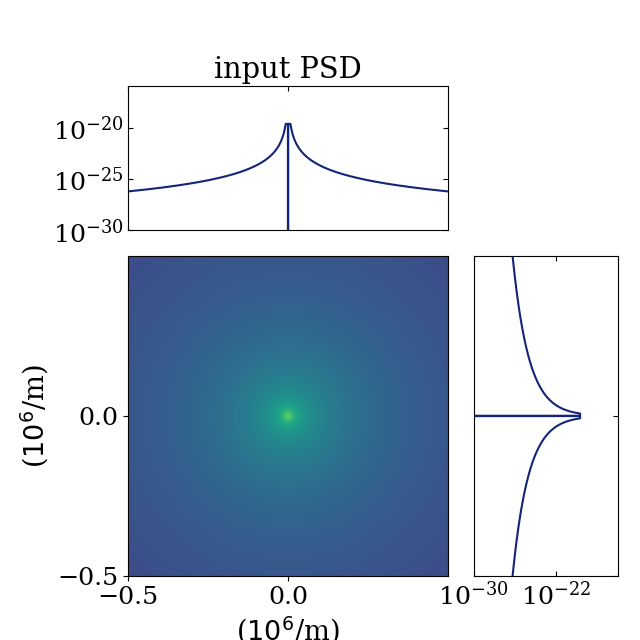

In [13]:
image = b4pt.Image2Plot(Cq, qx*1e-6, qy*1e-6)
image.legends = ['input PSD', '($10^6$/m)', '($10^6$/m)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.Scale=1
image.plt_limits = [1e-30, 1e-16]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

<IPython.core.display.Javascript object>


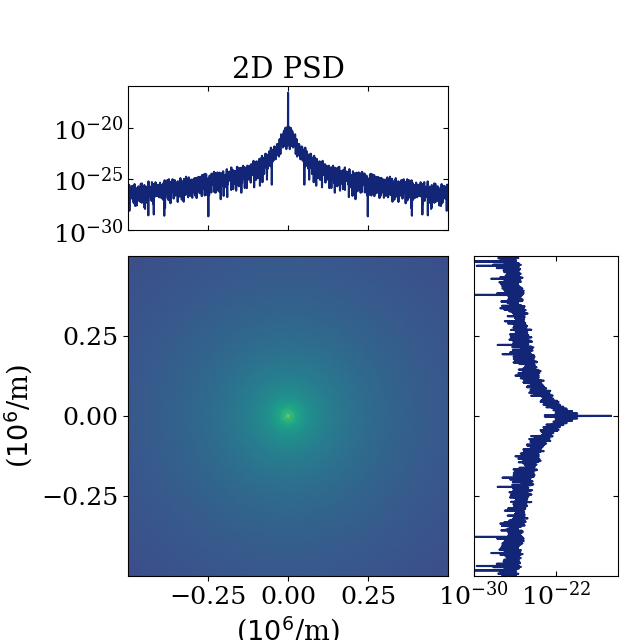

In [14]:
# 2D PSD calculation
psd_2d, fxbis, fybis = srw_uti_mtrl_psd_2D(surf, axis_x, axis_y, pad=False)
cut_x_psd_2d = psd_2d[int(n/2), :]
cut_x_psd_2d = cut_x_psd_2d[fxbis>0]
axis_x_psd_2d = fxbis[fxbis>0]

image = b4pt.Image2Plot(psd_2d, fxbis*1e-6, fybis*1e-6)
image.legends = ['2D PSD', '($10^6$/m)', '($10^6$/m)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.Scale=1
image.plt_limits = [1e-30, 1e-16]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

In [15]:
# 1D PSD calculation of a profile cut
cutx = surf[int(n/2), :]
psf_x, fx = srw_uti_mtrl_psd_1D(cutx, axis_x, positive_side=True)

# azimuthally averaged PSD from a 2D PSF calculation
psf_avg, f_avg = srw_uti_mtrl_psd_avg(surf, axis_x, axis_y, pad=False)

# input PSD cuts
cut_x_Cq = Cq[int(n/2), :]
cut_x_Cq = cut_x_Cq[qx>0]
axis_x_Cq = qx[qx>0]

<IPython.core.display.Javascript object>


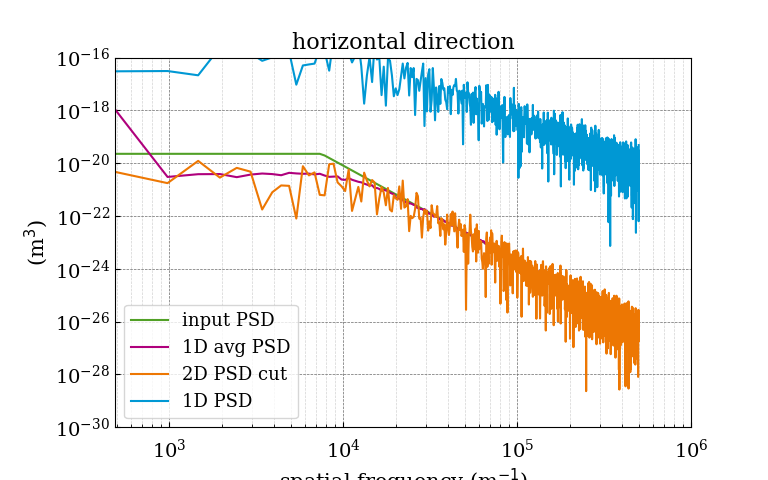

In [16]:
image = b4pt.Image2Plot(cut_x_Cq, axis_x_Cq)
image.AspectRatio = False
image.LaTex = True
image.legends = ['horizontal direction', 'spatial frequency (m$^{-1}$)', '(m$^3$)']
image.Scale = 3
image.ColorScheme = 1
image.label = 'input PSD'
image.grid = True 
image.sort_class()
b4pt.plot_1D(image, Enable=False, Hold=False)

image.image =  psf_avg
image.x = f_avg
image.ColorScheme = 2
image.label = '1D avg PSD'
b4pt.plot_1D(image, Enable=False, Hold=True)

image.image = cut_x_psd_2d
image.x = axis_x_psd_2d
image.ColorScheme = 3
image.label = '2D PSD cut'
b4pt.plot_1D(image, Enable=False, Hold=True)

image.image = psf_x
image.x = fx
image.ColorScheme = 4
image.label = '1D PSD'
image.ax_limits = [lower_f_limit*0.5, upper_f_limit, 1e-30, 1e-16]
b4pt.plot_1D(image, Enable=True, Hold=True)

## example 3 - taylored PSD

In [17]:
sigma = 3e-6
exponent = -3.6
PixelWidth = 1e-6
m = 2048
n = 2048
surf, axis_y, axis_x, Cq, qy, qx = fractal_surf(sigma,
                                             exponent,
                                             PixelWidth,
                                             m , n,
                                             qr=0,     # roll off frequency
                                             symmetry=True,
                                             dist=1,   # 0 - uniform; 1 Gaussian phase random distribution
                                             seed=17,  # seed for random phase
                                             psd=True, # we set this to True to have Cq, qx, qy returned - PSD and it's axes
                                             C=None)   # it is possible to add a pre calculated PSD as long as it has the 
                                                       # same shape as Cq and qx and qy are on the same scale

lower_f_limit = 1/axis_x[-1]
upper_f_limit = 1/PixelWidth

rms = np.sqrt(np.mean(surf**2))*1e6
print('rms value: %.3f um'%rms)

rms value: 3.000 um


### Surface generation

In [18]:
# profile to be added to surf

surfbis, s_axis, t_axis = single_f_sin_bumps_2d(_size_tang=axis_y[-1]-axis_y[0], _size_sag=axis_x[-1]-axis_x[0],
                          _npt=len(axis_y), _nps=len(axis_x), _b_amp=2e-6, _b_freq_t=None, _b_per_t=50e-6,
                          _b_freq_s=None, _b_per_s=200e-6, _b_phase=0, _b_offset=0, _file_path=None)

surf += surfbis

surfbis, s_axis, t_axis = single_f_sin_bumps_2d(_size_tang=axis_y[-1]-axis_y[0], _size_sag=axis_x[-1]-axis_x[0],
                          _npt=len(axis_y), _nps=len(axis_x), _b_amp=2e-6, _b_freq_t=None, _b_per_t=500e-6,
                          _b_freq_s=None, _b_per_s=50e-6, _b_phase=0, _b_offset=0, _file_path=None)

surf += surfbis

rms = np.sqrt(np.mean(surf**2))*1e6
print('rms value: %.3f um'%rms)

rms value: 3.605 um


<IPython.core.display.Javascript object>


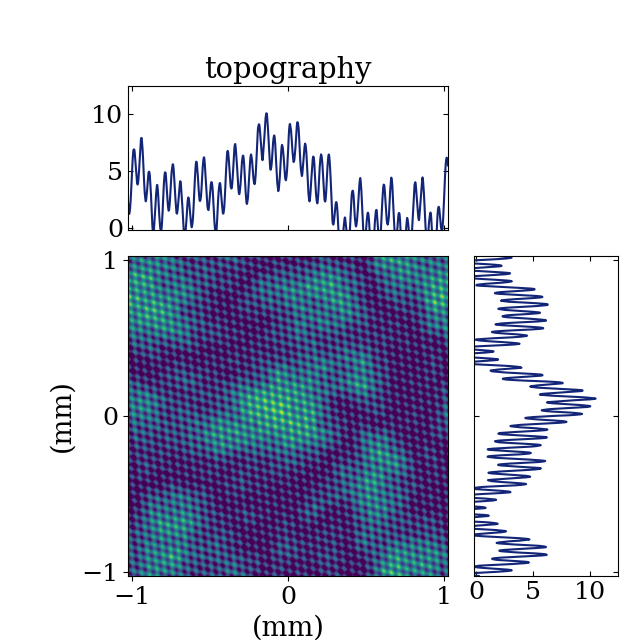

In [19]:
image = b4pt.Image2Plot(surf*1e6, axis_x*1e3, axis_y*1e3)
image.legends = ['topography', '(mm)', '(mm)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.plt_limits = [-0.2, np.amax(surf*1e6)*1.05]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

### PSD calculation

<IPython.core.display.Javascript object>


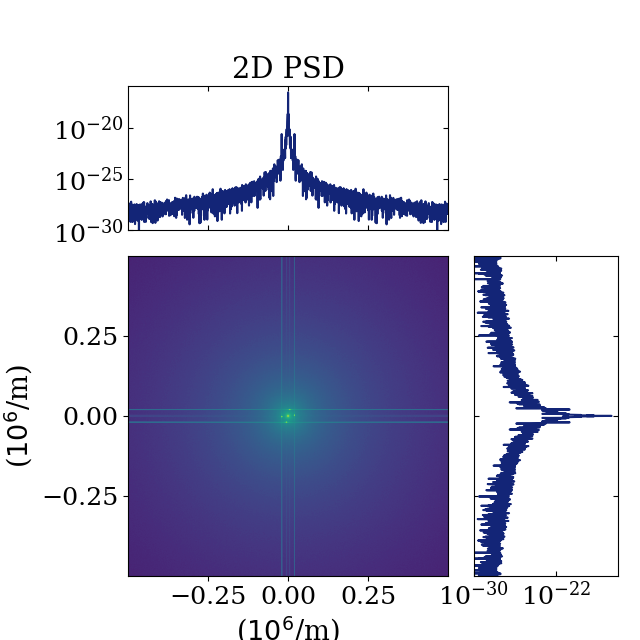

In [20]:
# 2D PSD calculation
psd_2d, fxbis, fybis = srw_uti_mtrl_psd_2D(surf, axis_x, axis_y, pad=False)
cut_x_psd_2d = psd_2d[int(n/2), :]
cut_x_psd_2d = cut_x_psd_2d[fxbis>0]
axis_x_psd_2d = fxbis[fxbis>0]

image = b4pt.Image2Plot(psd_2d, fxbis*1e-6, fybis*1e-6)
image.legends = ['2D PSD', '($10^6$/m)', '($10^6$/m)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.Scale=1
image.plt_limits = [1e-30, 1e-16]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

### Surface recalculation

In [21]:
sigma = 3e-6
exponent = -3.6
PixelWidth = 1e-6
m = 2048
n = 2048
surf, axis_y, axis_x, Cq, qy, qx = fractal_surf(rms*1e-6,
                                             None,
                                             PixelWidth,
                                             m , n,
                                             qr=0,     # roll off frequency
                                             symmetry=False,
                                             dist=0,   # 0 - uniform; 1 Gaussian phase random distribution
                                             seed=None,  # seed for random phase
                                             psd=True, # we set this to True to have Cq, qx, qy returned - PSD and it's axes
                                             C=psd_2d)   # it is possible to add a pre calculated PSD as long as it has the 
                                                       # same shape as Cq and qx and qy are on the same scale

lower_f_limit = 1/axis_x[-1]
upper_f_limit = 1/PixelWidth

rms = np.sqrt(np.mean(surf**2))*1e6
print('rms value: %.3f um'%rms)

rms value: 3.605 um


<IPython.core.display.Javascript object>


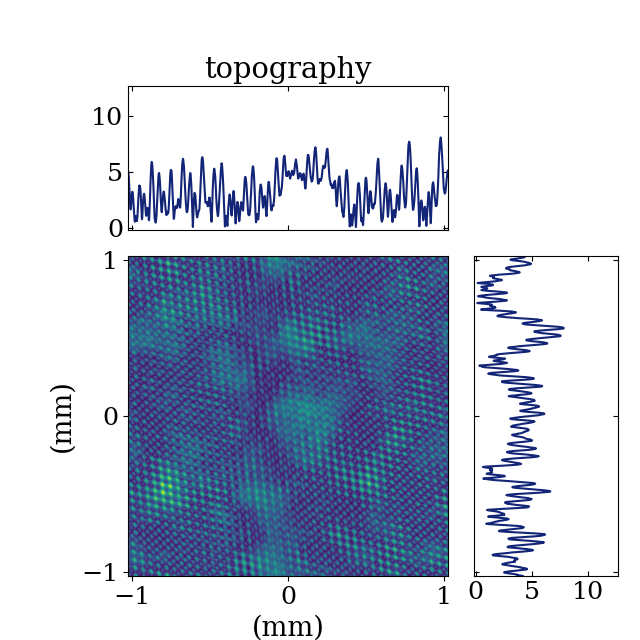

In [22]:
image = b4pt.Image2Plot(surf*1e6, axis_x*1e3, axis_y*1e3)
image.legends = ['topography', '(mm)', '(mm)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.plt_limits = [-0.2, np.amax(surf*1e6)*1.05]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

<IPython.core.display.Javascript object>


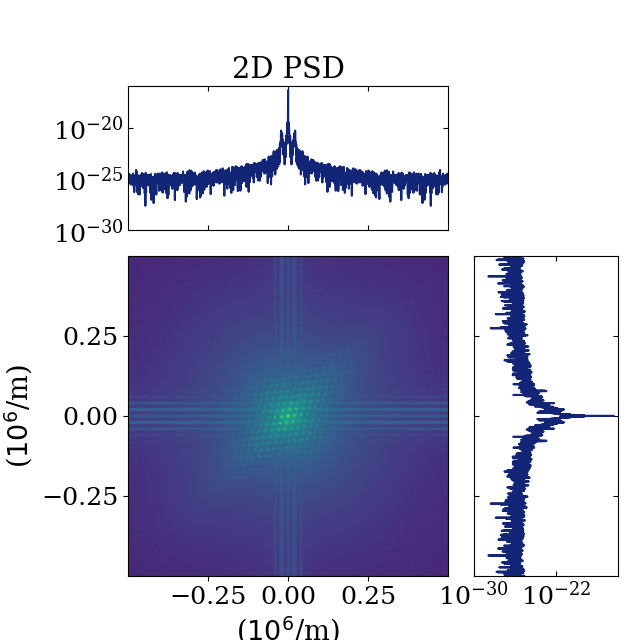

In [23]:
# 2D PSD calculation
psd_2d, fxbis, fybis = srw_uti_mtrl_psd_2D(surf, axis_x, axis_y, pad=False)
cut_x_psd_2d = psd_2d[int(n/2), :]
cut_x_psd_2d = cut_x_psd_2d[fxbis>0]
axis_x_psd_2d = fxbis[fxbis>0]

image = b4pt.Image2Plot(psd_2d, fxbis*1e-6, fybis*1e-6)
image.legends = ['2D PSD', '($10^6$/m)', '($10^6$/m)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.Scale=1
image.plt_limits = [1e-30, 1e-16]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

## example 4 - PSF and topographies (non uniqueness of solutions)

In [24]:
sigma = 3e-6
exponent = -3.6
PixelWidth = 1e-6
m = 2048
n = 2048
surf1, axis_y, axis_x, Cq, qy, qx = fractal_surf(sigma,
                                             exponent,
                                             PixelWidth,
                                             m , n,
                                             qr=0,     # roll off frequency
                                             symmetry=True,
                                             dist=1,   # 0 - uniform; 1 Gaussian phase random distribution
                                             seed=None,# seed for random phase
                                             psd=True, # we set this to True to have Cq, qx, qy returned - PSD and it's axes
                                             C=None)   # it is possible to add a pre calculated PSD as long as it has the 
                                                       # same shape as Cq and qx and qy are on the same scale

surf2, axis_y, axis_x, Cq, qy, qx = fractal_surf(sigma,
                                             exponent,
                                             PixelWidth,
                                             m , n,
                                             qr=0,     # roll off frequency
                                             symmetry=True,
                                             dist=1,   # 0 - uniform; 1 Gaussian phase random distribution
                                             seed=None,# seed for random phase
                                             psd=True, # we set this to True to have Cq, qx, qy returned - PSD and it's axes
                                             C=None)   # it is possible to add a pre calculated PSD as long as it has the 
                                                       # same shape as Cq and qx and qy are on the same scale
    
surf3, axis_y, axis_x, Cq, qy, qx = fractal_surf(sigma,
                                             exponent,
                                             PixelWidth,
                                             m , n,
                                             qr=0,     # roll off frequency
                                             symmetry=True,
                                             dist=1,   # 0 - uniform; 1 Gaussian phase random distribution
                                             seed=None,# seed for random phase
                                             psd=True, # we set this to True to have Cq, qx, qy returned - PSD and it's axes
                                             C=None)   # it is possible to add a pre calculated PSD as long as it has the 
                                                       # same shape as Cq and qx and qy are on the same scale

<IPython.core.display.Javascript object>


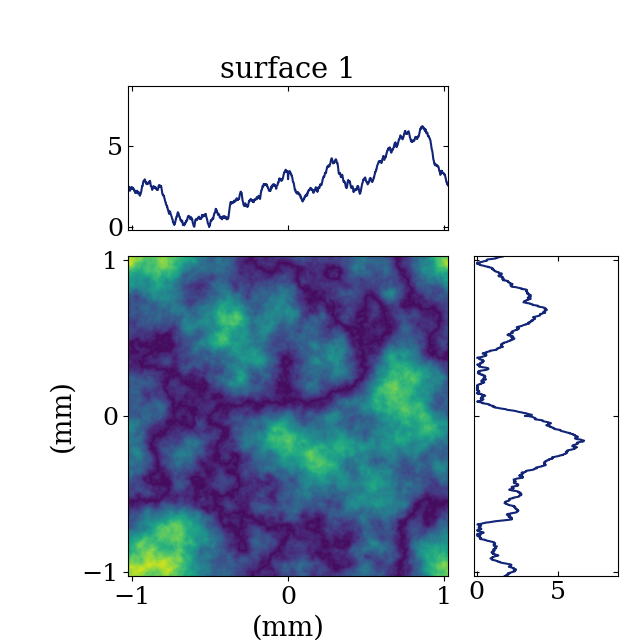

In [25]:
image = b4pt.Image2Plot(surf1*1e6, axis_x*1e3, axis_y*1e3)
image.legends = ['surface 1', '(mm)', '(mm)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.plt_limits = [-0.2, np.amax(surf1*1e6)*1.05]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

<IPython.core.display.Javascript object>


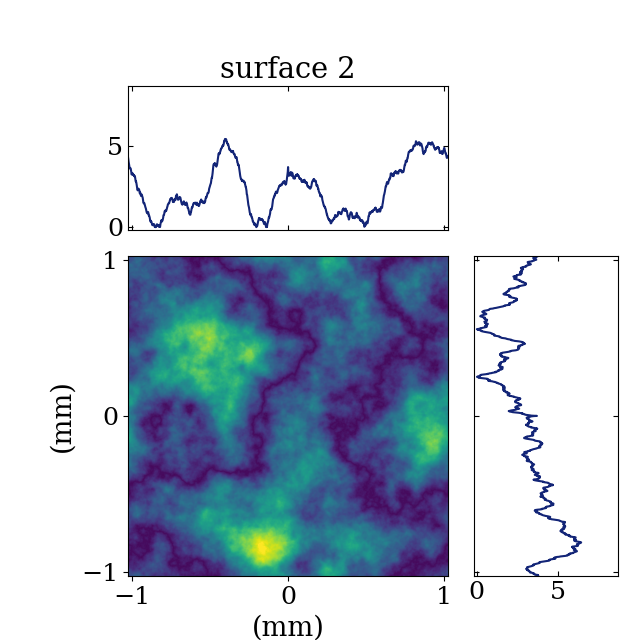

In [26]:
image = b4pt.Image2Plot(surf2*1e6, axis_x*1e3, axis_y*1e3)
image.legends = ['surface 2', '(mm)', '(mm)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.plt_limits = [-0.2, np.amax(surf1*1e6)*1.05]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

<IPython.core.display.Javascript object>


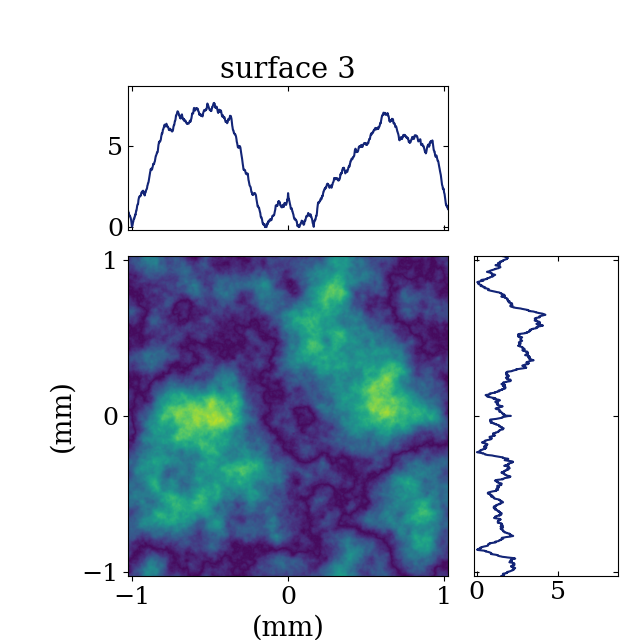

In [27]:
image = b4pt.Image2Plot(surf3*1e6, axis_x*1e3, axis_y*1e3)
image.legends = ['surface 3', '(mm)', '(mm)']
image.Colorbar = True
image.LaTex = True
image.AspectRatio = True
image.ColorScheme = 7
image.FontsSizeScale = 1.3
image.plt_limits = [-0.2, np.amax(surf1*1e6)*1.05]
image.sort_class()
b4pt.plot_2D_cuts(image, Enable=True, Silent=False)

In [28]:
psd_2d1, fxbis, fybis = srw_uti_mtrl_psd_2D(surf1, axis_x, axis_y, pad=False)
cut_x_psd_2d1 = psd_2d1[int(n/2), :]
cut_x_psd_2d1 = cut_x_psd_2d1[fxbis>0]
axis_x_psd_2d = fxbis[fxbis>0]

psd_2d2, fxbis, fybis = srw_uti_mtrl_psd_2D(surf2, axis_x, axis_y, pad=False)
cut_x_psd_2d2 = psd_2d2[int(n/2), :]
cut_x_psd_2d2 = cut_x_psd_2d2[fxbis>0]
axis_x_psd_2d = fxbis[fxbis>0]

psd_2d3, fxbis, fybis = srw_uti_mtrl_psd_2D(surf3, axis_x, axis_y, pad=False)
cut_x_psd_2d3 = psd_2d3[int(n/2), :]
cut_x_psd_2d3 = cut_x_psd_2d3[fxbis>0]
axis_x_psd_2d = fxbis[fxbis>0]

# input PSD cuts
cut_x_Cq = Cq[int(n/2), :]
cut_x_Cq = cut_x_Cq[qx>0]
axis_x_Cq = qx[qx>0]

<IPython.core.display.Javascript object>


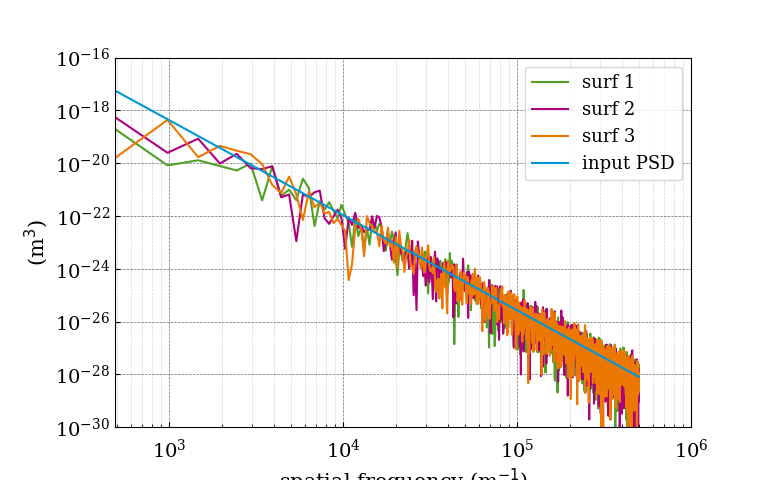

In [29]:
image = b4pt.Image2Plot(cut_x_psd_2d1, axis_x_psd_2d)
image.AspectRatio = False
image.LaTex = True
image.legends = ['', 'spatial frequency (m$^{-1}$)', '(m$^3$)']
image.Scale = 3
image.ColorScheme = 1
image.label = 'surf 1'
image.grid = True 
image.sort_class()
b4pt.plot_1D(image, Enable=False, Hold=False)

image.image =  cut_x_psd_2d2
image.x = axis_x_psd_2d
image.ColorScheme = 2
image.label = 'surf 2'
b4pt.plot_1D(image, Enable=False, Hold=True)

image.image = cut_x_psd_2d3
image.x = axis_x_psd_2d
image.ColorScheme = 3
image.label = 'surf 3'
b4pt.plot_1D(image, Enable=False, Hold=True)

image.image = cut_x_Cq
image.x = axis_x_Cq
image.ColorScheme = 4
image.label = 'input PSD'
image.ax_limits = [lower_f_limit*0.5, upper_f_limit, 1e-30, 1e-16]
b4pt.plot_1D(image, Enable=True, Hold=True)

<hr style="border:1px solid gray">

## Some literarature




- <div class="csl-entry">Jacobs, T. D. B., Junge, T., &#38; Pastewka, L. (2017). Quantitative characterization of surface topography using spectral analysis. <i>Surface Topography: Metrology and Properties</i>, <i>5</i>(1), 013001. https://doi.org/10.1088/2051-672X/AA51F8</div> (see also: https://arxiv.org/abs/1607.03040)


- <div class="csl-entry">Mack, C. A. (2013). Generating random rough edges, surfaces, and volumes. <i>Applied Optics, Vol. 52, Issue 7, Pp. 1472-1480</i>, <i>52</i>(7), 1472–1480. https://doi.org/10.1364/AO.52.001472</div>


- <div class="csl-entry">Church, E. L., Jenkinson, H. A., &#38; Zavada, J. M. (1979). Relationship between Surface Scattering and Microtopographic Features. <i>Https://Doi.Org/10.1117/12.7972337</i>, <i>18</i>(2), 125–136. https://doi.org/10.1117/12.7972337</div>


- <div class="csl-entry">Church, E. L., &#38; Takacs, P. Z. (1994). <i>BASIC program for power spectrum estimation. Revision</i>. https://doi.org/10.2172/10192650</div>


- <div class="csl-entry">Elson, J. M., &#38; Bennett, J. M. (1995). Calculation of the power spectral density from surface profile data. <i>Applied Optics, Vol. 34, Issue 1, Pp. 201-208</i>, <i>34</i>(1), 201–208. https://doi.org/10.1364/AO.34.000201</div>


- <div class="csl-entry">Duparré, A., Notni, G., Bennett, J. M., Steinert, J., Ferre-Borrull, J., &#38; Gliech, S. (2002). Surface characterization techniques for determining the root-mean-square roughness and power spectral densities of optical components. <i>Applied Optics, Vol. 41, Issue 1, Pp. 154-171</i>, <i>41</i>(1), 154–171. https://doi.org/10.1364/AO.41.000154</div>